In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
# !pip uninstall datasets -y
# !pip install torch==2.2 torchvision torchaudio lightning transformers datasets chess numpy pandas scikit-learn

In [3]:
from datasets import Dataset, DatasetDict, load_dataset, load_from_disk, load_dataset
from lightning_training import *
from data_process.tokenizers import FullMoveTokenizerNoEOS

import pandas as pd
import sqlite3 as db
import torch
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from nanoGPT.model import GPT, GPTConfig
from lightning_training import *


In [4]:
dataset = DatasetDict.load_from_disk("./data/huggingface_datasets/elo_bins/split/elo_1100")

In [5]:
dataset

DatasetDict({
    train: Dataset({
        features: ['index', 'id', 'date', 'white_elo', 'black_elo', 'result', 'ply', 'ply_30s', 'piece_uci'],
        num_rows: 6000000
    })
    valid: Dataset({
        features: ['index', 'id', 'date', 'white_elo', 'black_elo', 'result', 'ply', 'ply_30s', 'piece_uci'],
        num_rows: 100000
    })
    test: Dataset({
        features: ['index', 'id', 'date', 'white_elo', 'black_elo', 'result', 'ply', 'ply_30s', 'piece_uci'],
        num_rows: 100000
    })
})

<Axes: >

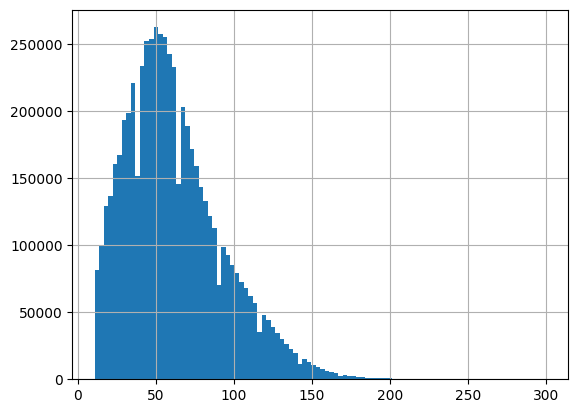

In [5]:
train_df = dataset['train'].to_pandas()
games = train_df['piece_uci']
lengths = games.apply(lambda x: len(x.split()))
lengths.hist(bins=100)

In [7]:
min(lengths), max(lengths)

(11, 300)

In [11]:
tokenizer = FullMoveTokenizerNoEOS()

model_config = GPTConfig(
    block_size=301,
    vocab_size=len(tokenizer.vocab),
    n_layer=8,
    n_head=8,
    n_embd=512,
    bias=False,
)

# model_config = GPTConfig(
#     block_size=301,
#     vocab_size=len(tokenizer.vocab),
#     n_layer=4,
#     n_head=4,
#     n_embd=256,
#     bias=False,
# )


pl_model = LightningGPT(model_config)


number of parameters: 27.27M


In [22]:
data_module = DataModuleMaiaTraining(dataset, num_workers=8, batch_size=64, max_game_length=300)

: 

In [12]:
tensorboard_logger = pl.loggers.TensorBoardLogger(save_dir="./lightning_logs/rating_bins/", name=f"elo_1900")
early_stopping = pl.callbacks.EarlyStopping(monitor="val_loss", patience=1, mode="min")

trainer = pl.Trainer(
    accelerator="gpu",
    max_epochs=10,
    callbacks=[pl.callbacks.RichProgressBar(), early_stopping],
    # logger=tensorboard_logger,
    # precision="bf16-mixed",
    # default_root_dir=
    # fast_dev_run=True
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [8]:
checkpoint_elo_1100 = "./lightning_logs/rating_bins/elo_1100/version_3/checkpoints/epoch=9-step=937500.ckpt"
checkpoint_elo_1200 = "./lightning_logs/rating_bins/elo_1200/version_0/checkpoints/epoch=9-step=937500.ckpt"
checkpoint_elo_1300 = "./lightning_logs/rating_bins/elo_1300/version_3/checkpoints/epoch=9-step=937500.ckpt"
checkpoint_elo_1400 = "./lightning_logs/rating_bins/elo_1400/version_2/checkpoints/epoch=9-step=937500.ckpt"
checkpoint_elo_1500 = "./lightning_logs/rating_bins/elo_1500/version_1/checkpoints/epoch=9-step=937500.ckpt"
checkpoint_elo_1600 = "./lightning_logs/rating_bins/elo_1600/version_5/checkpoints/epoch=9-step=937500.ckpt"
checkpoint_elo_1700 = "./lightning_logs/rating_bins/elo_1700/version_1/checkpoints/epoch=9-step=937500.ckpt"
checkpoint_elo_1800 = "./lightning_logs/rating_bins/elo_1800/version_0/checkpoints/epoch=9-step=937500.ckpt"
checkpoint_elo_1900 = "./lightning_logs/rating_bins/elo_1900/version_2/checkpoints/epoch=9-step=937500.ckpt"

In [13]:
pl_model = LightningGPT(model_config)
# pl_model = LightningGPT.load_from_checkpoint(checkpoint_elo_1900, config=model_config)

number of parameters: 27.27M


In [14]:
torch.set_float32_matmul_precision("high")

In [ ]:
trainer.fit(
    model=pl_model,
    datamodule=data_module,
    # ckpt_path=checkpoint_elo_1900
)

In [29]:
checkpoints = {
    "elo_1100": checkpoint_elo_1100,
    "elo_1200": checkpoint_elo_1200,
    "elo_1300": checkpoint_elo_1300,
    "elo_1400": checkpoint_elo_1400,
    "elo_1500": checkpoint_elo_1500,
    "elo_1600": checkpoint_elo_1600,
    "elo_1700": checkpoint_elo_1700,
    "elo_1800": checkpoint_elo_1800,
    "elo_1900": checkpoint_elo_1900,
}

dataset_dict_prefix = "./data/huggingface_datasets/elo_bins/split/elo_"


data_modules = {
    f"bin_{elo}": DataModuleMaiaTraining(DatasetDict.load_from_disk(f"{dataset_dict_prefix}{elo}"), num_workers=8, batch_size=64, max_game_length=300)
    for elo in range(1100, 2000, 100)
}

In [ ]:
trainer = pl.Trainer(
    accelerator="gpu"
)

scores = {}



for elo in range(1100, 2000, 100):
    checkpoint = checkpoints[f"elo_{elo}"]
    pl_model = LightningGPT.load_from_checkpoint(checkpoint, config=model_config)

    model_scores = {}

    for elo_key, data_module in data_modules.items():
        score = trainer.test(model=pl_model, datamodule=data_module, verbose=False)
        model_scores[elo_key] = score[0]

    scores[f"model_{elo}"] = model_scores

In [33]:
torch.save(scores, "./lightning_logs/rating_bins/scores.pt")

In [6]:
scores = torch.load("./lightning_logs/rating_bins/scores.pt")
scores

{'model_1100': {'bin_1100': {'test_loss': 1.7886048555374146,
   'test_acc': 0.4458704888820648},
  'bin_1200': {'test_loss': 1.7833119630813599,
   'test_acc': 0.44662144780158997},
  'bin_1300': {'test_loss': 1.7887814044952393, 'test_acc': 0.444404661655426},
  'bin_1400': {'test_loss': 1.7950561046600342,
   'test_acc': 0.4423803985118866},
  'bin_1500': {'test_loss': 1.813390851020813,
   'test_acc': 0.43760862946510315},
  'bin_1600': {'test_loss': 1.827532172203064, 'test_acc': 0.4336306154727936},
  'bin_1700': {'test_loss': 1.850812554359436, 'test_acc': 0.4280512034893036},
  'bin_1800': {'test_loss': 1.8754063844680786,
   'test_acc': 0.4215216338634491},
  'bin_1900': {'test_loss': 1.9014829397201538,
   'test_acc': 0.4143434762954712}},
 'model_1200': {'bin_1100': {'test_loss': 1.7949007749557495,
   'test_acc': 0.44443807005882263},
  'bin_1200': {'test_loss': 1.782178521156311, 'test_acc': 0.4468008577823639},
  'bin_1300': {'test_loss': 1.7806981801986694,
   'test_acc'

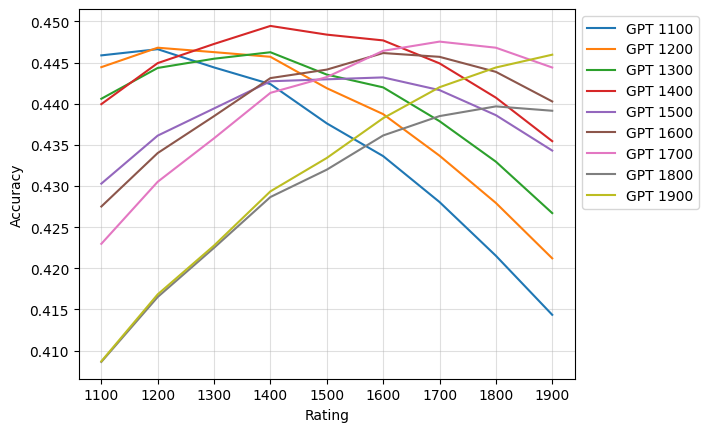

In [4]:
import matplotlib.pyplot as plt
from scipy.interpolate import make_interp_spline, BSpline


X = list(range(1100, 2000, 100))

for name, model_scores in scores.items():
    Y = [model_scores[f"bin_{elo}"]["test_acc"] for elo in range(1100, 2000, 100)]

    plt.plot(X, Y, label=f"GPT {name[-4:]}")
    # X_new = np.linspace(min(X), max(X), 300)
    # spl = make_interp_spline(X, Y, k=3)
    # Y_new = spl(X_new)

    # plt.plot(X_new, Y_new, label=name)

plt.xlabel("Rating")
plt.ylabel("Accuracy")
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.grid(alpha=0.4)
plt.show()

# x = list(results.keys())
# y = [result[0]["test_acc"] for result in results.values()]

# plt.plot(x, y)
# plt.grid()

# plt.show()

GPT 1100: (44.662144780159, 41.43434762954712) [44.58704888820648, 44.662144780159, 44.4404661655426, 44.23803985118866, 43.760862946510315, 43.36306154727936, 42.80512034893036, 42.15216338634491, 41.43434762954712]
GPT 1200: (44.68008577823639, 42.1207070350647) [44.44380700588226, 44.68008577823639, 44.62641477584839, 44.56983208656311, 44.188252091407776, 43.87332797050476, 43.3680534362793, 42.794036865234375, 42.1207070350647]
GPT 1300: (44.62505877017975, 42.670392990112305) [44.05979514122009, 44.434213638305664, 44.54650580883026, 44.62505877017975, 44.35358941555023, 44.19817328453064, 43.787556886672974, 43.29536259174347, 42.670392990112305]
GPT 1400: (44.944941997528076, 43.544402718544006) [43.99435520172119, 44.49307024478912, 44.725918769836426, 44.944941997528076, 44.839125871658325, 44.76886987686157, 44.49027478694916, 44.0733939409256, 43.544402718544006]
GPT 1500: (44.319283962249756, 43.028390407562256) [43.028390407562256, 43.61182153224945, 43.94199550151825, 44

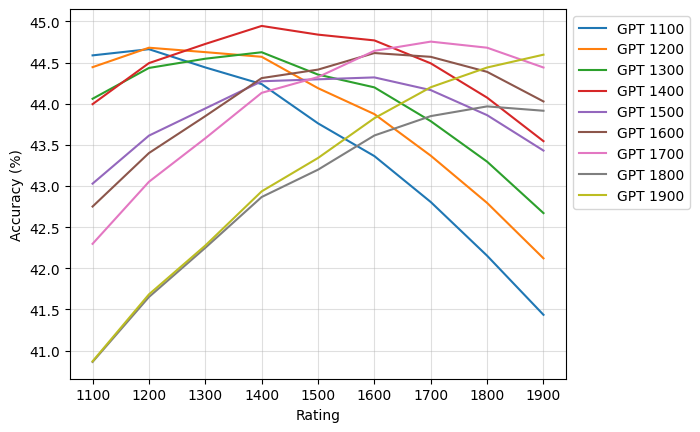

In [9]:
import matplotlib.pyplot as plt
from scipy.interpolate import make_interp_spline, BSpline

X = list(range(1100, 2000, 100))

for name, model_scores in scores.items():
    Y = [model_scores[f"bin_{elo}"]["test_acc"] * 100 for elo in range(1100, 2000, 100)]

    print(f"GPT {name[-4:]}: {max(Y), min(Y)} {Y}")

    plt.plot(X, Y, label=f"GPT {name[-4:]}")

plt.xlabel("Rating")
plt.ylabel("Accuracy (%)")  # Change ylabel to include percentage
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.grid(alpha=0.4)
plt.show()